# `AML — Task 2:` Heart rhythm classification from raw ECG signals
---

In [1]:
# For TQDM :
#! python3.6 -m pip install ipywidgets
#! python3.6 -m pip install --upgrade jupyter
#! jupyter nbextension enable --py widgetsnbextension

In [1]:
import numpy as np
import pandas as pd
import biosppy.signals.ecg as ecg
import biosppy.signals.tools as tools
import neurokit2 as nk
from biosppy.plotting import plot_ecg
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
tqdm.pandas()

In [50]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFpr, SelectFdr, SelectFwe, f_classif, chi2, mutual_info_classif, SelectKBest
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,\
                             AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from pywt import wavedec
from operator import itemgetter

---
## Dataset import and export to `csv`

In [3]:
def load_from_csv(extension="", drop_id = True):
    X_train = pd.read_csv('data/X_train' + extension + '.csv')
    y_train = pd.read_csv('data/y_train' + extension + '.csv')
    X_test  = pd.read_csv('data/X_test' + extension + '.csv')
    
    if drop_id:
        X_train = X_train.drop(columns=['id'])
        y_train = y_train.drop(columns=['id'])
        X_test  = X_test.drop(columns=['id'])
     
    return X_train, y_train, X_test

In [4]:
def export_to_csv(X_train, y_train, X_test, extension="_cleaned"):
    X_train.to_csv('data/X_train' + extension + '.csv', index=False)
    y_train.to_csv('data/y_train' + extension + '.csv', index=False)
    X_test.to_csv('data/X_test' + extension + '.csv', index=False)

## Submission export to `csv`

In [5]:
def create_submission(sub_id, pred, basepath='submissions/task2-sub'):
    result = pred.copy().rename(columns={0: 'y'})
    result['id'] = range(0, len(result))
    result = result[['id', 'y']]
    result.to_csv(basepath + str(sub_id) + '.csv', index=False)

## Plot helper functions

In [6]:
def plot_raw_signal_sample(raw_signal):
    # Some matplotlib setting 
    plt.rcParams["figure.figsize"] = (30, 5)
    plt.rcParams['lines.linewidth'] = 5
    plt.rcParams['xtick.labelsize'] = 24
    plt.rcParams['ytick.labelsize'] = 32
    plt.rcParams['axes.labelsize'] = 48
    plt.rcParams['axes.titlesize'] = 48

    fig, axs = plt.subplots(1, 1)

    seconds = np.arange(0, 600) / 30 
    x_labels = [0, 5, 10, 15, 20]

    ax = axs
    
    measurements = raw_signal.dropna().to_numpy(dtype='float32')
    # Get a subsequence of a signal and downsample it for visualization purposes
    measurements = measurements[1000:7000:10] 
    # convert volts to millivolts
    measurements /= 1000
    ax.plot(seconds, measurements, color='k')
    ax.set_xticks(x_labels)

    fig.tight_layout()

    # Display x- and y-labels for the whole plot
    ax = fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [mV]')            
    plt.show()

In [7]:
def plot_templates(templates):
    pd.DataFrame(np.mean(templates, axis=0)).plot()
    pd.DataFrame(templates.transpose()).plot()

---
## Data processing

### Helpers

In [8]:
def extract_stats_from(features_series: list) -> pd.Series:
    # pd.describe().drop(count) returns 7 interesting features (min, max, std...)
    stats = pd.concat([pd.Series(s, dtype=np.float64).describe().drop(["count"]) for s in features_series], ignore_index=True)
    stats = stats.append(pd.Series([pd.Series(s, dtype=np.float64).skew() for s in features_series]), ignore_index=True)
    stats = stats.append(pd.Series([pd.Series(s, dtype=np.float64).kurtosis() for s in features_series]), ignore_index=True)
    return stats

In [9]:
def extract_qpeaks_features(filtered: np.array, rpeaks: np.array, window_size=50):
    qpeaks = [rpeak - window_size + np.argmin(filtered[rpeak-window_size:rpeak]) for rpeak in rpeaks]
    qpeaks_amplitudes = [filtered[qpeak] for qpeak in qpeaks]
    return qpeaks, qpeaks_amplitudes

In [10]:
def extract_speaks_features(filtered: np.array, rpeaks: np.array, window_size=50):
    speaks = [rpeak + np.argmin(filtered[rpeak:rpeak+window_size]) for rpeak in rpeaks]
    speaks_amplitudes = [filtered[speak] for speak in speaks]
    return speaks, speaks_amplitudes

In [11]:
def extract_euclidean_Rpeak_specific_points_features(templates):
    beats = templates
    
    beat = np.mean(beats, axis=0) #Might be improved
    rpeak = np.argmax(beat) #Might be improved
    
    key_points = np.zeros((4, 2))
    results = np.full(4, np.nan)
    
    key_points[0, :] = max(enumerate(beat[0:40]), key=itemgetter(1))
    key_points[1, :] = min(enumerate(beat[75:85]), key=itemgetter(1))
    key_points[2, :] = min(enumerate(beat[95:105]), key=itemgetter(1))
    key_points[3, :] = max(enumerate(beat[150:180]), key=itemgetter(1))
    
    key_points[1][0] += 75
    key_points[2][0] += 95
    key_points[3][0] += 150
    
    rvalue= beat[rpeak]
    
    max_x = max(np.append(key_points[:, 0], rpeak))
    min_x = min(np.append(key_points[:, 0], rpeak))
    max_y = max(np.append(key_points[:, 1], rvalue))
    min_y = min(np.append(key_points[:, 1], rvalue))
    
    rpeak_normalized = (rpeak-min_x)/(max_x-min_x)
    rvalue_normalized = (rvalue-min_y)/(max_y-min_y)
    
    for i in range(key_points.shape[0]):
        x = key_points[i][0]
        y = key_points[i][1]
        x_normalized = (x-min_x)/(max_x-min_x)
        y_normalized = (y-min_y)/(max_y-min_y)
        
        results[i] = np.linalg.norm([rpeak_normalized-x_normalized, rvalue_normalized-y_normalized])
    
    return results

In [12]:
def extract_ECG_features_index(no_nans, sampling_rate=300, method='dwt'):
    cleaned_signal = nk.ecg_clean(no_nans, sampling_rate=sampling_rate)
    rpeaks = nk.ecg_findpeaks(cleaned_signal, sampling_rate=sampling_rate)["ECG_R_Peaks"]

    PQRST_time_dic = {}
    PQRST_time_dic["ECG_R_Peaks"] = rpeaks

    try:
        _, waves = nk.ecg_delineate(cleaned_signal, rpeaks, sampling_rate=300, method=method, show=False)
        PQRST_time_dic.update({column_name: pd.DataFrame(waves[column_name]).dropna().to_numpy(dtype=int).reshape(-1) for column_name in list(waves.keys())})
    
    except Exception as e:
        print("No PQST-peak could be found, problem with nk.ecg_delineate.")         

    return PQRST_time_dic

In [13]:
def extract_ECG_amplitudes(no_nans, ECG_feature_index_dic):
    peaks_columns=["ECG_R_Peaks", "ECG_P_Peaks", "ECG_Q_Peaks", "ECG_S_Peaks", "ECG_T_Peaks"]
    amplitudes = []
    for col_name in peaks_columns:
        amplitudes.append([no_nans[index] for index in ECG_feature_index_dic.get(col_name, [])])
    return amplitudes

In [14]:
def extract_ECG_offset_onset_diff(ECG_feature_index_dic):
    peaks_having_onsets = ["P", "R", "T"]

    peaks_duration =  [[] for i in range(len(peaks_having_onsets)) ]
    for i, p in enumerate(peaks_having_onsets):
        onset_column_name = "ECG_" + p + "_Onsets"
        offset_column_name = "ECG_" + p + "_Offsets"
        peaks_duration[i] = [offset-onset for offset, onset in zip(ECG_feature_index_dic.get(offset_column_name, []), ECG_feature_index_dic.get(onset_column_name, []))]

    return peaks_duration

In [15]:
#To be continued to extract all the other features such as indexes distances
def extract_ECG_features(no_nans, sampling_rate=300, method='dwt'):
    ECG_feature_index_dic = extract_ECG_features_index(no_nans, sampling_rate=sampling_rate, method=method)
    amplitudes = extract_ECG_amplitudes(no_nans, ECG_feature_index_dic)
    onset_offset_diff = extract_ECG_offset_onset_diff(ECG_feature_index_dic)
    return amplitudes, onset_offset_diff

### Feature extraction

In [24]:
def extract_features(time_series: pd.Series, sampling_rate=300) -> pd.Series:
    # Drop nan values in the time series
    no_nans = time_series.dropna()
    
    # Extract main features from ECG
    ts, filtered, rpeaks, _, templates, _, heart_rate = ecg.ecg(no_nans, sampling_rate, show=False)
    assert len(rpeaks) > 1, 'ECG cannot have a single R peak'
    assert len(templates) > 1, 'ECG cannot have a single heartbeat'
    
    # Extract Q,R,S peak features
    rpeaks_amplitude = [filtered[rpeak] for rpeak in rpeaks]
    qpeaks, qpeaks_amplitude = extract_qpeaks_features(filtered, rpeaks)
    speaks, speaks_amplitude = extract_speaks_features(filtered, rpeaks)
    
    # Extract RR, QRS durations features
    rr_durations = [r2 - r1 for r1, r2 in zip(rpeaks, rpeaks[1:])]
    qrs_durations = [speak - qpeak for qpeak, speak in zip(qpeaks, speaks)]
    
    # Extract RR differences
    rr_differences = [rr2 - rr1 for rr1, rr2 in zip(rr_durations, rr_durations[1:])]
    
    # Extract QRS direction features
    qrs_direction = [q + r + s for q, r, s in zip(qpeaks, rpeaks, speaks)]
    
    # Extract Q/R ratio features
    qr_ratio = [q / r for q, r in zip(qpeaks, rpeaks)]
    
    #TODO: Extract SNR ratio (http://www.cinc.org/archives/2011/pdf/0609.pdf)
    snr = np.quantile(np.std(templates, axis=0), 0.35)
    
    # Use this to go from index differences to seconds
    index_to_time = ts[-1] / len(filtered)
    # Extract pNNx (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1767394/)
    pNNs = []
    for i in [28, 50]:#np.arange(5, 55, 5):
        pNNs.append((np.array(rr_durations) * index_to_time > i * 0.001).sum() / len(rr_durations))
    pNNs = pd.Series(pNNs)
    
    # Extract log(RMSSD) (log of root mean square successive differences, linked to heart rate variability (HRV))
    logRMSSD = np.log(np.sqrt(np.mean(np.array(rr_differences) ** 2)))
    
    # Extract power features
    freqs, power = tools.power_spectrum(filtered, sampling_rate, decibel=True)
    total_power = tools.band_power(freqs, power, [0, 0.4], decibel=True)[0]
    vlf_power = tools.band_power(freqs, power, [0, 0.04], decibel=True)[0]
    lf_power = tools.band_power(freqs, power, [0.04, 0.15], decibel=True)[0]
    hf_power = tools.band_power(freqs, power, [0.15, 0.4], decibel=True)[0]
    lfhf_ratio = lf_power / hf_power
    lf_power_norm = lf_power / (total_power - vlf_power)
    hf_power_norm = hf_power / (total_power - vlf_power)
    
    # Extract beats skew and kurtosis (https://paperswithcode.com/paper/heartbeat-classification-fusing-temporal-and)
    skews = pd.DataFrame(templates).skew(axis=1)
    kurtosiss = pd.DataFrame(templates).kurtosis(axis=1)
    
    #Extract ECG features from neurokit
    ecg_amplitude, onset_offset_diff = extract_ECG_features(no_nans)
    ppeaks_amplitudes = ecg_amplitude[1]
    tpeaks_amplitudes = ecg_amplitude[4]
    ponset_offset_diff = onset_offset_diff[0]
    ronset_offset_diff = onset_offset_diff[1]
    tonset_offset_diff = onset_offset_diff[2]
    
    # Extract statistics
    ecg_features = extract_stats_from([
        rpeaks_amplitude, qpeaks_amplitude, speaks_amplitude,
        ppeaks_amplitudes, tpeaks_amplitudes, 
        ponset_offset_diff, ronset_offset_diff, tonset_offset_diff,
        rr_durations, qrs_durations, rr_differences, qrs_direction, 
        qr_ratio, skews, kurtosiss
    ])
    
    # Extract different standard deviations
    sdsd = np.std(rr_differences) # could be optimized, already computed
    sdnn = np.std(rr_durations) # could be optimized, already computed
    sd1 = (1 / np.sqrt(2)) * sdsd
    sd2 = 2 * sdnn**2 - sd1**2
    sd1sd2ratio = sd1 / sd2
    s = 3.14159 * sd1 * sd2
    
    
    #Extract wavelets
    coeffs = np.mean([wavedec(template, 'db1', level=3) for template in templates], axis=0, dtype=object)
    wavelet = coeffs[0]
    wavelet_features = pd.Series(wavelet)
    

    euclidean_dist_features = pd.Series(extract_euclidean_Rpeak_specific_points_features(templates))

    
    
    return ecg_features.append(pd.Series([snr, 
                                          logRMSSD, 
                                          total_power, 
                                          vlf_power,
                                          lf_power, 
                                          hf_power,
                                          lfhf_ratio, 
                                          lf_power_norm, 
                                          hf_power_norm,
                                          sd1,
                                          sd2, 
                                          sd1sd2ratio, 
                                          s]), ignore_index=True).append(pNNs, ignore_index=True).append(wavelet_features, ignore_index=True).append(euclidean_dist_features, ignore_index=True)
    

---
## Data standardization

In [17]:
def standardize_data(X_train, X_test):
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return pd.DataFrame(X_train_scaled), pd.DataFrame(X_test_scaled)

---
## Feature Selection

In [18]:
def remove_constant_features(X_train, X_test, verbose=True):
    non_constant_features_mask = X_train.apply(pd.Series.nunique) != 1
    X_train_selected_features = X_train.loc[:, non_constant_features_mask]
    X_test_selected_features = X_test.loc[:, non_constant_features_mask]
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of constant values ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%).")
    
    return X_train_selected_features, X_test_selected_features

In [19]:
def remove_too_correlated_features(X_train, X_test, threshold=0.98, verbose=True):
    X_train_corr_ = X_train.corr()

    X_train_too_correlated = (X_train_corr_.mask(
        np.tril(np.ones([len(X_train_corr_)]*2, dtype=bool))).abs() > threshold).any()
    
    X_train_selected_features = X_train.loc[:, (~X_train_too_correlated)]
    X_test_selected_features = X_test.loc[:, (~X_train_too_correlated)]
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of correlation with another feature > {threshold} ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%).")

    return X_train_selected_features, X_test_selected_features

In [46]:
def remove_useless_features(X_train, y_train, X_test, selector_type="kbest", stat=f_classif, k=150, verbose=1):
    # See https://stats.stackexchange.com/questions/328358/fpr-fdr-and-fwe-for-feature-selection
    # and https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
    
    assert selector_type in ["fpr", "fdr", "fwe", "kbest"], "Unrecognised selector type"
    assert stat in [f_classif, chi2, mutual_info_classif], "Unrecognised stat"
    selector = None
    if selector_type=="kbest":
        selector = SelectKBest(stat, k=k) # modify here
    if selector_type == "fpr":
        selector = SelectFpr(stat)
    elif selector_type == "fdr":
        selector = SelectFdr(stat)
    elif selector_type == "fwe":
        selector = SelectFwe(stat)    
    selector.fit(X_train, y_train)
    X_train_selected_features = pd.DataFrame(selector.transform(X_train))
    X_test_selected_features = pd.DataFrame(selector.transform(X_test))
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of complicated p-value stuff we don't understand ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%).")
        
    return X_train_selected_features, X_test_selected_features

---
## Outlier detection

In [21]:
def remove_outliers(X_train, y_train, contamination='auto', verbose=1, method="LocalOutlierFactor"):
    clf = None
    if method == "LocalOutlierFactor":
        clf = LocalOutlierFactor(contamination=contamination)
    elif method == "IsolationForest":
        clf = IsolationForest(contamination=contamination, random_state=0, verbose=verbose)
    else:
        raise AttributeError(f"Unvalid argument for method, must be 'LocalOutlierFactor' or 'IsolationForest', not '{method}'")
        
    outliers_mask = pd.Series(clf.fit_predict(X_train)).map({1:1, -1:0}) #Mask with 0 for outliers and 1 for non outliers
    
    if verbose:
        print(f"Detected {(outliers_mask == 0).sum()} outliers with method {method}, out of {outliers_mask.shape[0]} samples ({100 * (outliers_mask == 0).sum() / outliers_mask.shape[0]:.2f}%).")
    
    # Remove outliers from the training set
    X_train = np.array(X_train)[outliers_mask == 1, :]
    y_train = np.array(y_train)[outliers_mask == 1]
    
    return pd.DataFrame(X_train), pd.DataFrame(y_train)

---
## Model definition

In [22]:
def grid_search(model, params, X_train, y_train, clear=False):
    gs = GridSearchCV(model, params, cv=5, verbose=3, scoring='f1_micro', error_score='raise')
    gs.fit(X_train, y_train)
    
    if clear:
        clear_output(wait=True)
    print(f"{type(gs.best_estimator_).__name__} best validation score is {gs.best_score_:.5f} +- {gs.cv_results_['std_test_score'][gs.best_index_]:.5f},\nobtained with {gs.best_params_}")
    
    return gs

---
## Main Pipeline

### Load dataset

In [23]:
X_train_raw, y_train_raw, X_test_raw = load_from_csv()

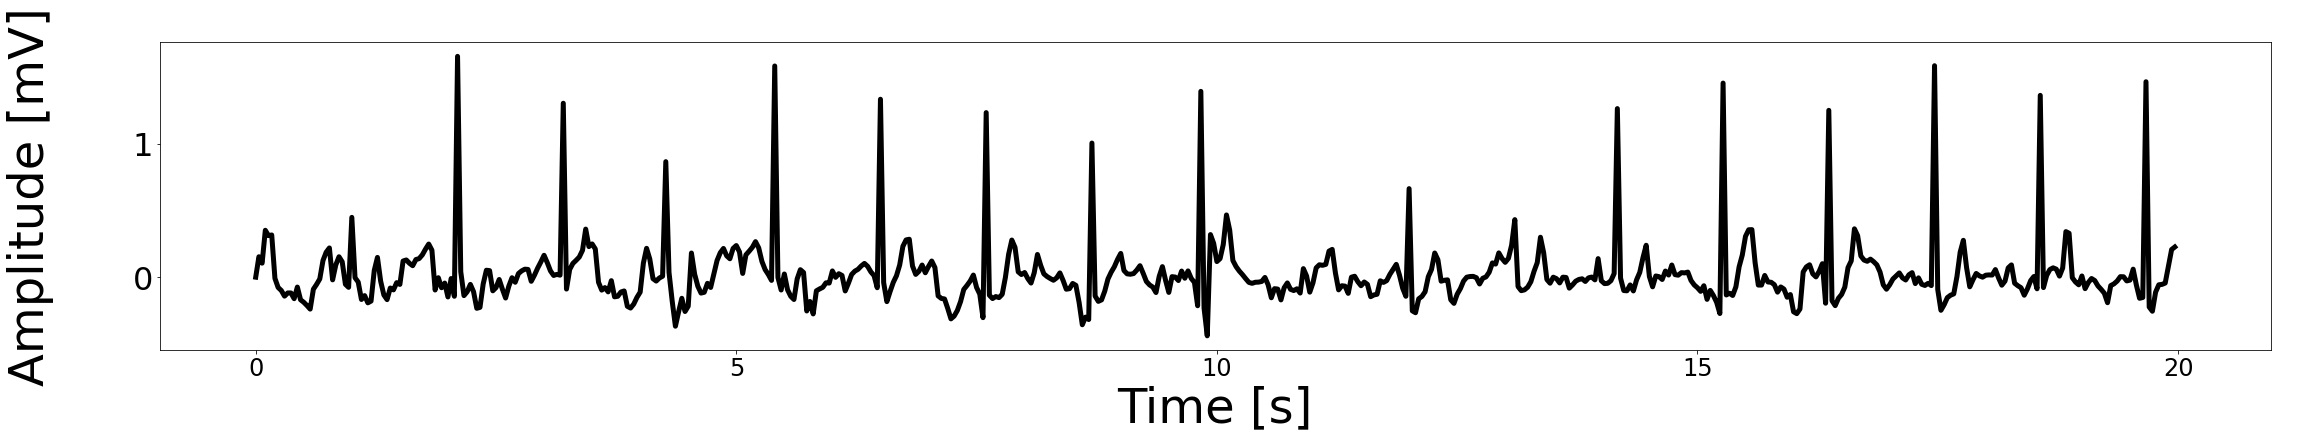

In [88]:
plot_raw_signal_sample(X_train_raw.loc[693, :])

### Extract features

In [25]:
X_train = X_train_raw.apply(extract_features, axis=1)

/home/loic/Enter/envs/InternetAnalytics/lib/python3.9/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/loic/Enter/envs/InternetAnalytics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/loic/Enter/envs/InternetAnalytics/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/loic/Enter/envs/InternetAnalytics/lib/python3.9/site-packages/neurokit2/signal/signal_period.py:60: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


No PQST-peak could be found, problem with nk.ecg_delineate.
No PQST-peak could be found, problem with nk.ecg_delineate.
No PQST-peak could be found, problem with nk.ecg_delineate.
No PQST-peak could be found, problem with nk.ecg_delineate.
No PQST-peak could be found, problem with nk.ecg_delineate.
No PQST-peak could be found, problem with nk.ecg_delineate.


In [26]:
X_test = X_test_raw.apply(extract_features, axis=1)

No PQST-peak could be found, problem with nk.ecg_delineate.
No PQST-peak could be found, problem with nk.ecg_delineate.
No PQST-peak could be found, problem with nk.ecg_delineate.


In [27]:
print(f"X_train has {X_train.isna().sum().sum()} null values ({X_train.isna().sum().sum()/X_train.size:.5f}%).")
print(f"X_test has {X_test.isna().sum().sum()} null values ({X_test.isna().sum().sum()/X_test.size:.5f}%).")

X_train has 618 null values (0.00068%).
X_test has 536 null values (0.00089%).


### Standardize data

In [28]:
X_train_stand, X_test_stand = standardize_data(X_train, X_test)

### Impute data

In [29]:
imputer = KNNImputer(n_neighbors=6, weights='uniform').fit(X_train_stand)
X_train_imp = pd.DataFrame(imputer.transform(X_train_stand))
X_test_imp = pd.DataFrame(imputer.transform(X_test_stand))

In [30]:
print(f"X_train has {X_train_imp.isna().sum().sum()} null values.")
print(f"X_test has {X_test_imp.isna().sum().sum()} null values.")

X_train has 0 null values.
X_test has 0 null values.


### Select features

In [69]:
X_train_1, X_test_1 = remove_constant_features(X_train_imp, X_test_imp)

0 features removed because of constant values (0.00%).


In [70]:
X_train_2, X_test_2 = remove_too_correlated_features(X_train_1, X_test_1, threshold=0.97)

23 features removed because of correlation with another feature > 0.97 (12.99%).


In [71]:
X_train_3, X_test_3 = remove_useless_features(X_train_2, np.array(y_train_raw).ravel(), X_test_2, selector_type="kbest", stat=f_classif, k=149)

5 features removed because of complicated p-value stuff we don't understand (3.25%).


In [72]:
X_train_4, y_train = remove_outliers(X_train_3, y_train_raw, method="LocalOutlierFactor")

Detected 301 outliers with method LocalOutlierFactor, out of 5117 samples (5.88%).


In [73]:
y_train = np.array(y_train).ravel()

### Train models

In [80]:
gs_svc = grid_search(SVC(),
                     {
                         # Need to play with degree parameter for poly kernel
                         "kernel": ["rbf"],
                         "C": [2, 2.25, 2.5, 2.75],
                         "gamma": ["scale", "auto"],
                         "class_weight": ["balanced", None],
                         "decision_function_shape": ["ovo", "ovr"],
                         "random_state": [0],
                     },
                     X_train_4,
                     y_train,
                     clear=True)

SVC best validation score is 0.79838 +- 0.00889,
obtained with {'C': 2, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 0}


In [79]:
gs_random_forest = grid_search(RandomForestClassifier(),
                               {
                                   "n_estimators": [300], #np.arange(100, 300, 200),
                                   "min_samples_split": [4], #np.arange(2, 8, 1),
                                   "min_samples_leaf": [1,40], #np.arange(1, 9, 2),
                                   "max_depth": [None, 10],
                                   "class_weight": [None, "balanced"],
                                   "random_state": [0], 
                               },
                               X_train_4,
                               y_train,
                               clear=True)

RandomForestClassifier best validation score is 0.82683 +- 0.01275,
obtained with {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300, 'random_state': 0}


In [74]:
gs_gbc = grid_search(GradientBoostingClassifier(),
                     {
                         "learning_rate": [0.1], #Rather small
                         "n_estimators": [300], #
                         "subsample": [0.7],#Try 0.6?
                         "criterion": ["mse"],
                         "min_samples_split": [4],
                         "min_samples_leaf": [40],
                         "max_depth": [10],
                         "max_features": ["auto"],
                         "random_state": [0],
                     },
                     X_train_4, 
                     y_train,
                     clear=True)

GradientBoostingClassifier best validation score is 0.84115 +- 0.00666,
obtained with {'criterion': 'mse', 'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 40, 'min_samples_split': 4, 'n_estimators': 300, 'random_state': 0, 'subsample': 0.7}


In [45]:
# No predict_proba
gs_knn = grid_search(KNeighborsClassifier(),
                     {
                         "n_neighbors": np.arange(2, 10, 1),
                         "weights": ["uniform", "distance"],
                     },
                     X_train_4, 
                     y_train,
                     clear=True)

KNeighborsClassifier best validation score is 0.74552 +- 0.00664,
obtained with {'n_neighbors': 7, 'weights': 'distance'}


In [46]:
# Takes ~6min to train the 2*5 epochs, but scores of ~0.72
gs_gp = grid_search(GaussianProcessClassifier(),
                    {
                        "kernel": [None],
                        "multi_class": ["one_vs_rest", "one_vs_one"],
                        "random_state": [0],
                    },
                    X_train_4, 
                    y_train,
                    clear=True)

GaussianProcessClassifier best validation score is 0.71458 +- 0.00433,
obtained with {'kernel': None, 'multi_class': 'one_vs_one', 'random_state': 0}


In [47]:
gs_ab = grid_search(AdaBoostClassifier(),
                    {
                        "base_estimator": [None],
                        "n_estimators": [50, 300],
                        "learning_rate": [0.1, 1.0],
                        "random_state": [0],
                    },
                    X_train_4, 
                    y_train,
                    clear=True)

AdaBoostClassifier best validation score is 0.73717 +- 0.01183,
obtained with {'base_estimator': None, 'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0}


In [82]:
gs_etc = grid_search(ExtraTreesClassifier(),
                    {
                        "n_estimators": [750],
                        "criterion": ["gini"],
                        "bootstrap": [False],
                        "min_samples_split" :[7, 10],
                        "min_samples_leaf": [1,2],
                        "max_features": ["auto"],
                        "class_weight": ["balanced"],
                        "random_state": [0],
                    },
                    X_train_4, 
                    y_train,
                    clear=True)

ExtraTreesClassifier best validation score is 0.81624 +- 0.00689,
obtained with {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 750, 'random_state': 0}


In [48]:
# No predict_proba
gs_ridge = grid_search(RidgeClassifier(),
                       {
                           "alpha": [0.1, 1, 5],
                           "class_weight": ["balanced", None],
                           "random_state": [0],
                       },
                       X_train_4,
                       y_train,
                       clear=True)

RidgeClassifier best validation score is 0.76222 +- 0.00770,
obtained with {'alpha': 0.1, 'class_weight': None, 'random_state': 0}


In [49]:
gs_logreg = grid_search(LogisticRegression(),
                        {
                            "penalty": ["l2"],
                            "C": [0.1, 0.5, 1, 5, 10],
                            "class_weight": ["balanced", None],
                            "random_state": [0],
                            "max_iter": [1000],
                            "solver": ["newton-cg", "lbfgs", "sag", "saga"],
                            "multi_class": ["auto", "ovr", "multinomial"]
                        },
                        X_train_4,
                        y_train,
                        clear=True)

LogisticRegression best validation score is 0.76771 +- 0.00640,
obtained with {'C': 1, 'class_weight': None, 'max_iter': 2000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 0, 'solver': 'saga'}


In [83]:
gs_mlp = grid_search(MLPClassifier(),
                     {
                         "hidden_layer_sizes":[(500, ), (1000)], #[(500, ), (100,), (40, 40, 30, 10), (40, 40), (100, 30, 10), (100, 100, 100), (15, 15, 15, 15, 15, 7)],
                         "alpha": [0.0001],
                         "activation": ['relu'],#['logistic', 'tanh', 'relu'],
                         "solver": ["adam"],
                         "early_stopping": [True],
                         "random_state": [0],
                     },
                     X_train_4,
                     y_train,
                     clear=True)

MLPClassifier best validation score is 0.78925 +- 0.01565,
obtained with {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (500,), 'random_state': 0, 'solver': 'adam'}


In [ ]:
# Only kept models with a predict proba function for soft voting + good val score
gs_ensemble = grid_search(VotingClassifier([('svc', SVC(probability=True, **gs_svc.best_params_)),
                                            ('rf', RandomForestClassifier(**gs_random_forest.best_params_)),
                                            ('gbc', GradientBoostingClassifier(**gs_gbc.best_params_)),
                                            ('etc', ExtraTreesClassifier(**gs_etc.best_params_))]),
                          {
                              "voting": ["soft"], #["hard", "soft"],
                          },
                          X_train_4, 
                          y_train,
                          clear=False)

In [87]:
# Only kept models with a predict proba function for soft voting + good val score
gs_ensemble_2 = grid_search(VotingClassifier([('rf', RandomForestClassifier(**gs_random_forest.best_params_)),
                                              ('gbc', GradientBoostingClassifier(**gs_gbc.best_params_)),
                                              ('etc', ExtraTreesClassifier(**gs_etc.best_params_))]),
                            {
                                "voting": ["soft"], #["hard", "soft"],
                            },
                            X_train_4, 
                            y_train,
                            clear=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .......................voting=soft;, score=0.843 total time= 5.3min
[CV 2/5] END .......................voting=soft;, score=0.842 total time= 5.5min
[CV 3/5] END .......................voting=soft;, score=0.843 total time= 5.7min
[CV 4/5] END .......................voting=soft;, score=0.832 total time= 5.5min
[CV 5/5] END .......................voting=soft;, score=0.848 total time= 5.5min
VotingClassifier best validation score is 0.84178 +- 0.00545,
obtained with {'voting': 'soft'}


In [ ]:
# Only kept models with a predict proba function for soft voting + good val score
gs_ensemble_3 = grid_search(VotingClassifier([('rf', RandomForestClassifier(**gs_random_forest.best_params_)),
                                              ('gbc', GradientBoostingClassifier(**gs_gbc.best_params_)),
                                              ('etc', ExtraTreesClassifier(**gs_etc.best_params_)),
                                              ('svc', SVC(probability=True, **gs_svc.best_params_)),
                                              ('mlp', MLPClassifier(**gs_mlp.best_params_))]),
                            {
                                "voting": ["soft"], #["hard", "soft"],
                            },
                            X_train_4, 
                            y_train,
                            clear=False)

In [84]:
# Only kept models with a predict proba function for soft voting + good val score
gs_ensemble_4 = grid_search(VotingClassifier([('rf', RandomForestClassifier(**gs_random_forest.best_params_)),
                                              ('gbc', GradientBoostingClassifier(**gs_gbc.best_params_))
                                             ]),
                            {
                                "voting": ["soft"], #["hard", "soft"],
                            },
                            X_train_4, 
                            y_train,
                            clear=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .......................voting=soft;, score=0.840 total time= 4.9min
[CV 2/5] END .......................voting=soft;, score=0.844 total time= 4.9min
[CV 3/5] END .......................voting=soft;, score=0.841 total time= 5.0min
[CV 4/5] END .......................voting=soft;, score=0.831 total time= 5.2min
[CV 5/5] END .......................voting=soft;, score=0.852 total time= 5.3min
VotingClassifier best validation score is 0.84157 +- 0.00671,
obtained with {'voting': 'soft'}


In [65]:
# All models => hard voting
gs_ensemble_5 = grid_search(VotingClassifier([('rf', RandomForestClassifier(**gs_random_forest.best_params_)),
                                              ('gbc', GradientBoostingClassifier(**gs_gbc.best_params_)),
                                              ('etc', ExtraTreesClassifier(**gs_etc.best_params_)),
                                              ('svc', SVC(probability=True, **gs_svc.best_params_)),
                                              ('mlp', MLPClassifier(**gs_mlp.best_params_)),
                                              ('knn', KNeighborsClassifier(**gs_knn.best_params_)),
                                              ('gp', GaussianProcessClassifier(**gs_gp.best_params_)),
                                              ('ada', AdaBoostClassifier(**gs_ab.best_params_)),
                                              ('ridge', RidgeClassifier(**gs_ridge.best_params_)),
                                              ('logreg', LogisticRegression(**gs_logreg.best_params_)),
                                             ]),
                                              
                            {
                                "voting": ["hard"], #["hard", "soft"],
                            },
                            X_train_4, 
                            y_train,
                            clear=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .......................voting=hard;, score=0.811 total time= 2.4min
[CV 2/5] END .......................voting=hard;, score=0.811 total time= 2.5min
[CV 3/5] END .......................voting=hard;, score=0.826 total time= 2.4min


/home/loic/Enter/envs/InternetAnalytics/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 4/5] END .......................voting=hard;, score=0.793 total time= 2.3min


/home/loic/Enter/envs/InternetAnalytics/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 5/5] END .......................voting=hard;, score=0.813 total time= 2.4min
VotingClassifier best validation score is 0.81067 +- 0.01037,
obtained with {'voting': 'hard'}


In [65]:
def find_best_k_percent(X_train_1, X_test_1, y_train_raw, ks, thresholds):
    print(f"""Testing all {len(thresholds) * len(ks)} possibilities.""")
    general_best_gbc=None
    best_k = None
    best_threshold = None
    best_X_train = None
    best_y_train = None
    best_X_test = None
    for k in ks:
        for threshold in thresholds:
            X_train_2, X_test_2 = remove_too_correlated_features(X_train_1, X_test_1, threshold=threshold)
            if k>X_train_2.shape[1]:
                k=X_train_2.shape[1]-5
            X_train_3, X_test_3 = remove_useless_features(X_train_2, np.array(y_train_raw).ravel(), X_test_2, selector_type="kbest", stat=f_classif, k=k)
            X_train_4, y_train = remove_outliers(X_train_3, y_train_raw, method="LocalOutlierFactor")
            y_train = np.array(y_train).ravel()
            gs_gbc = grid_search(GradientBoostingClassifier(),
                     {
                         "learning_rate": [0.1], #Rather small
                         "n_estimators": [100], #
                         "subsample": [0.7],#Try 0.6?
                         "criterion": ["mse"],
                         "min_samples_split": [4],
                         "min_samples_leaf": [40],
                         "max_depth": [10],
                         "max_features": ["auto"],
                         "random_state": [0],
                     },
                     X_train_4, 
                     y_train,
                     clear=True)
            
            if general_best_gbc is None or gs_gbc.best_score_ > general_best_gbc.best_score_:
                    general_best_gbc = gs_gbc
                    best_k=k
                    best_threshold=threshold
                    best_X_train = X_train_4
                    best_y_train = y_train
                    best_X_test = X_test_3
                    
    print(f"""\n\nThe best validation score obtained is {general_best_gbc.best_score_:.5f} 
    \With clean parameters:
    \tk: {best_k}
    \tthreshold: {best_threshold}
    """)    
    return general_best_gbc, best_X_train, best_y_train, best_X_test  

In [68]:
ks = [135, 140, 150, 155, 160, 165]
thresholds = [0.97, 0.98, 0.99, 1]

general_best_gbc, best_X_train, best_y_train, best_X_test = find_best_k_percent(X_train_1, X_test_1, y_train_raw, ks, thresholds)

GradientBoostingClassifier best validation score is 0.83721 +- 0.01072,
obtained with {'criterion': 'mse', 'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 40, 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 0, 'subsample': 0.7}


The best validation score obtained is 0.84012 
    \With clean parameters:
    	k: 149
    	threshold: 0.97
    


NameError: name 'general_best_svr' is not defined

---
## Generate new submission

In [91]:
model = gs_ensemble_2
sub_id = 54
prediction = pd.DataFrame(model.predict(X_test_3))

In [92]:
create_submission(sub_id, prediction)

**Solutions must be submitted on the [project website](https://aml.ise.inf.ethz.ch/task2/#submission).**